In [1]:
# libraries to import : 
import torch
from torch.utils.data import Dataset, Subset,DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from numpy import interp
from models.resnet import resnet10
import nibabel as nib
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# class for creating dataloaders: 
class CustomDataset(Dataset):
    def __init__(self, txt_file, base_dir=Path("."), transform=None):
        self.paths = []
        self.transform = transform

        with open(txt_file, "r") as f:
            for line in f:
                relative_path, label = line.strip().split()
                full_path = base_dir / relative_path
                self.paths.append((full_path, int(label)))

            
    def __getitem__(self, idx):
        file_path, label = self.paths[idx]
        zstack = nib.load(file_path)
        data = zstack.get_fdata().astype(np.float32)

        data = np.log1p(data)
        data_min, data_max = data.min(), data.max()
        data = (data - data_min) / (data_max - data_min) if data_max > data_min else np.zeros_like(data)
        data = torch.tensor(data).unsqueeze(0)
        

        if self.transform:
            subject = self.transform(subject)
            data = subject['image'].data  # still (1, D, H, W)

        data = torch.nn.functional.interpolate(
            data.unsqueeze(0), size=(32, 256, 256),
            mode='trilinear', align_corners=False
        ).squeeze(0)

        label = torch.tensor(label, dtype=torch.float32)
        return data, label

    def __len__(self):
        return len(self.paths)

    def get_file_path(self, idx):
        return self.paths[idx][0]


test_set = CustomDataset('data/ZStacksWTMUT/test.txt', base_dir=Path("data/"),transform=None)


test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [3]:
# model evaluation summary: 
model_paths = [ 
    "fold1.pth",
    "fold2.pth",
    "fold3.pth",
    "fold4.pth",
    "fold5.pth",
]

metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
}

for fold, model_path in enumerate(model_paths, 1):
    model = resnet10(sample_input_D=32, sample_input_H=256, sample_input_W=256, nclasses=1)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Fold {fold}"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.sigmoid(outputs).view(-1)
            preds = (probs > 0.5).int()

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    metrics['accuracy'].append(acc)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1'].append(f1)


print("\n===== Cross-Fold Test Summary =====")
for key in metrics:
    mean = np.mean(metrics[key])
    std = np.std(metrics[key])
    print(f"{key.capitalize():<10}: {mean:.4f} ± {std:.4f}")

Fold 5: 100%|███████████████████████████████████| 25/25 [00:29<00:00,  1.17s/it]


===== Cross-Fold Test Summary =====
Accuracy  : 0.9360 ± 0.0784
Precision : 1.0000 ± 0.0000
Recall    : 0.8769 ± 0.1507
F1        : 0.9273 ± 0.0891


In [4]:
# grad cam visualisation for explainability : 
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        # Forward hook to get feature maps
        self.fwd_hook = target_layer.register_forward_hook(self.save_activation)
        # Backward hook to get gradients
        self.bwd_hook = target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, input_tensor, class_idx=None):
        output = self.model(input_tensor) 
        if class_idx is None:
            class_idx = output.argmax(dim=1)

        loss = output[:, class_idx].sum() 
        self.model.zero_grad()
        loss.backward(retain_graph=True)

        pooled_grads = torch.mean(self.gradients, dim=[2, 3, 4], keepdim=True)

        weighted_activations = self.activations * pooled_grads
        cam = weighted_activations.sum(dim=1, keepdim=True) 

        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='trilinear', align_corners=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8) 
        return cam

    def remove_hooks(self):
        self.fwd_hook.remove()
        self.bwd_hook.remove()


Displaying all 32 slices


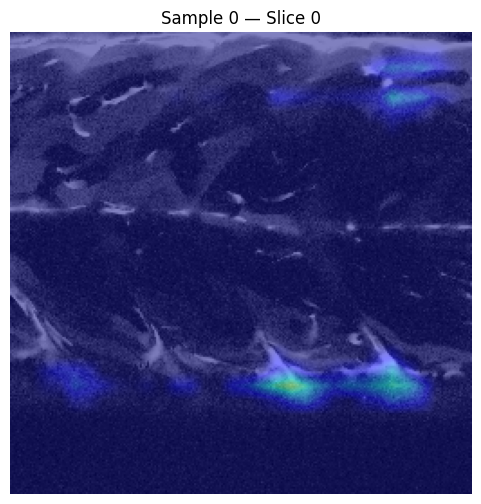

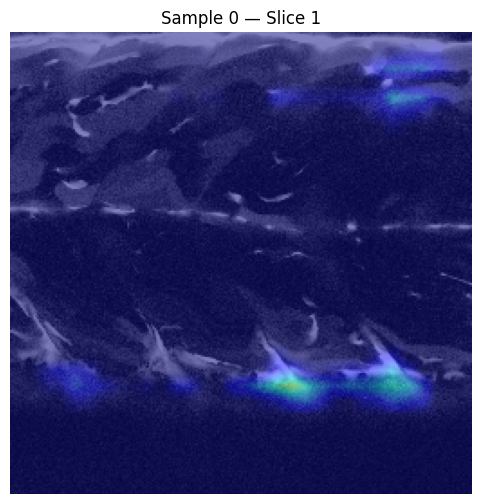

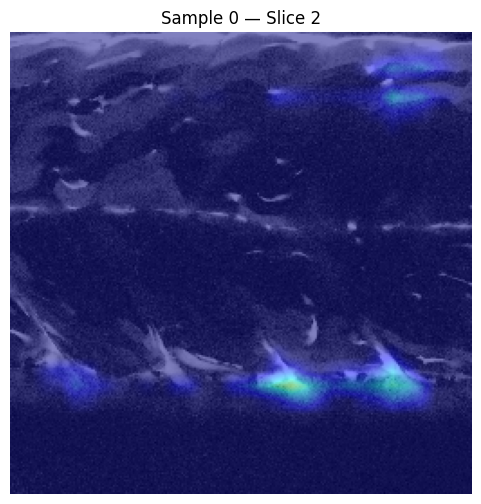

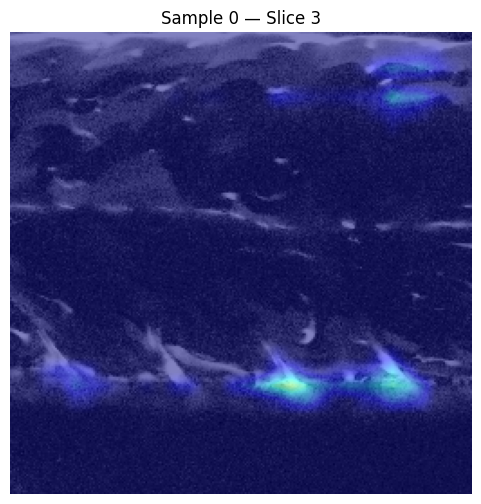

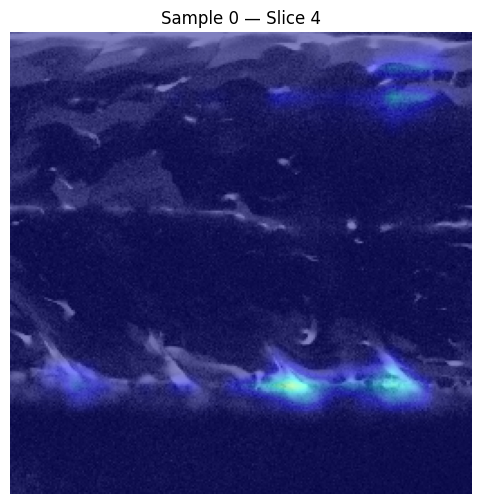

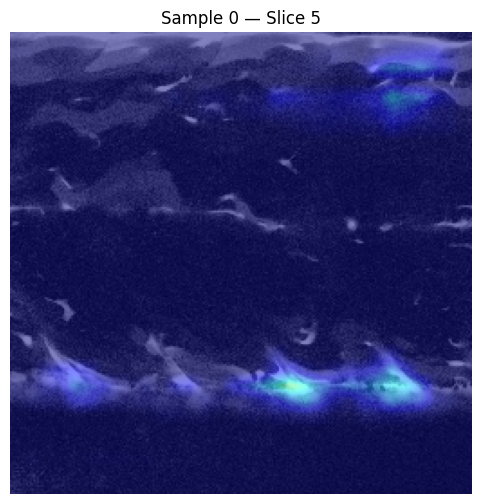

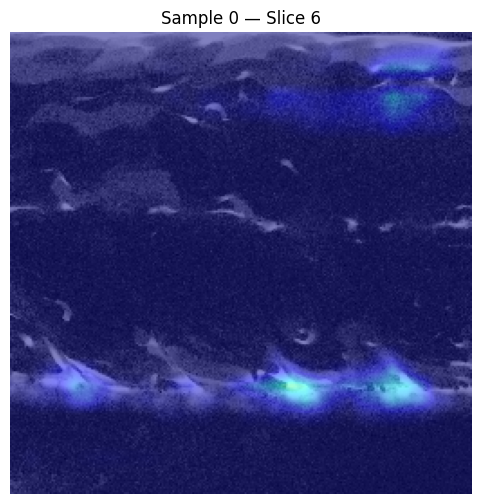

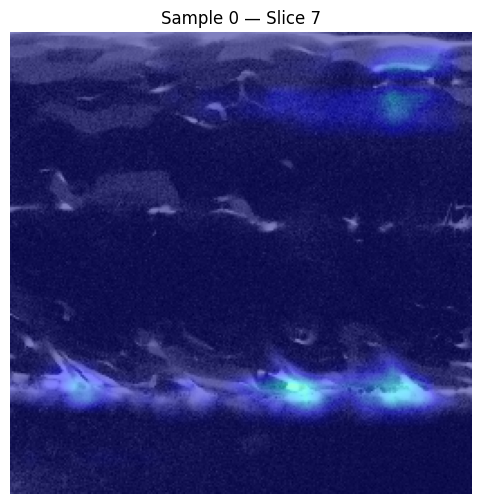

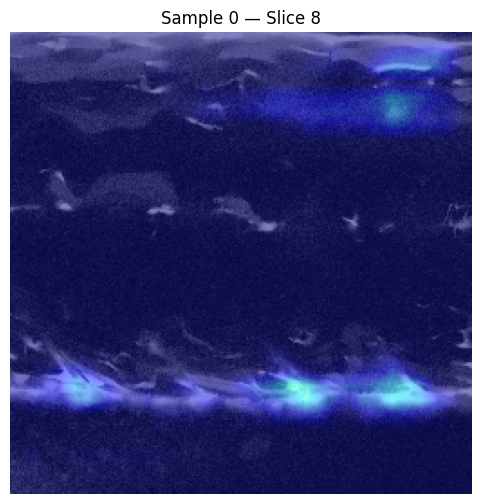

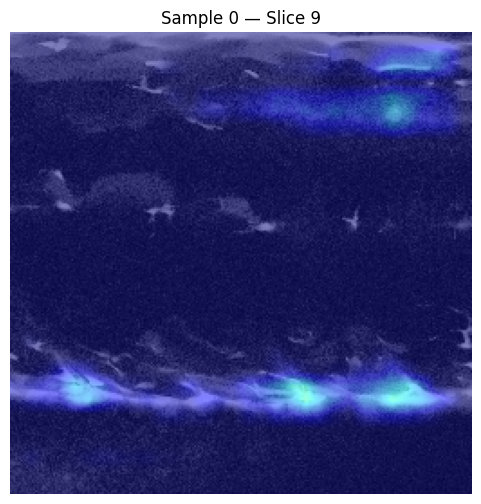

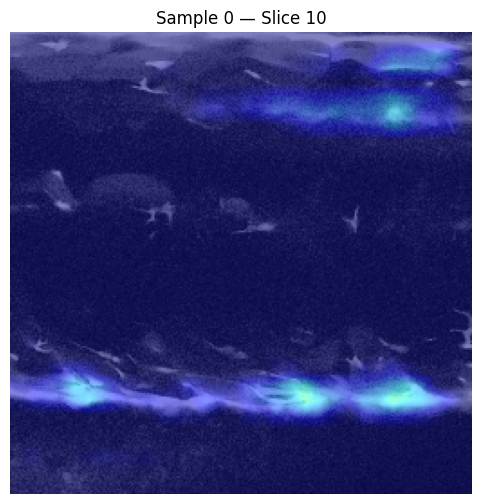

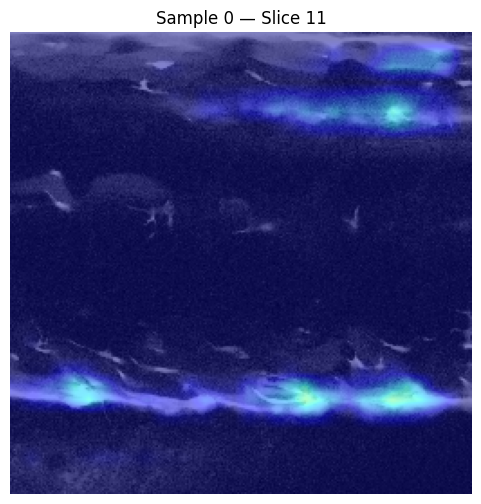

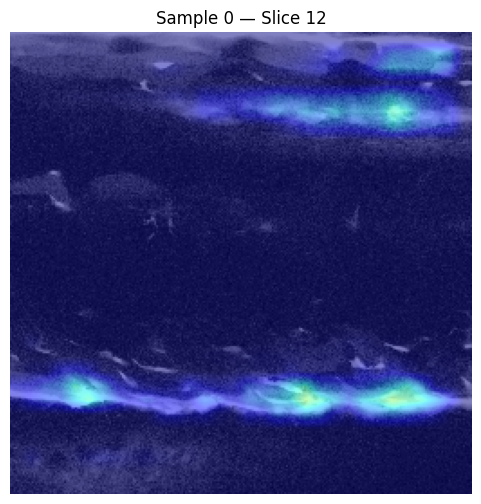

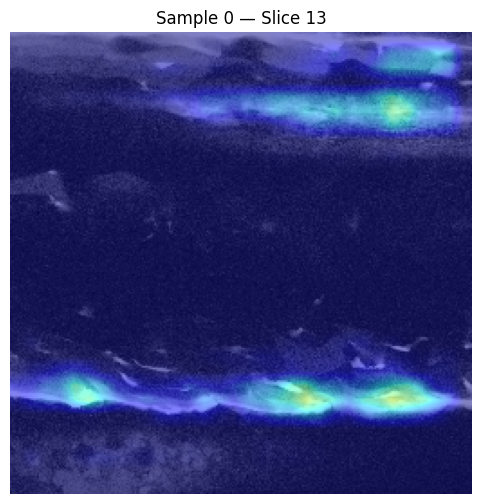

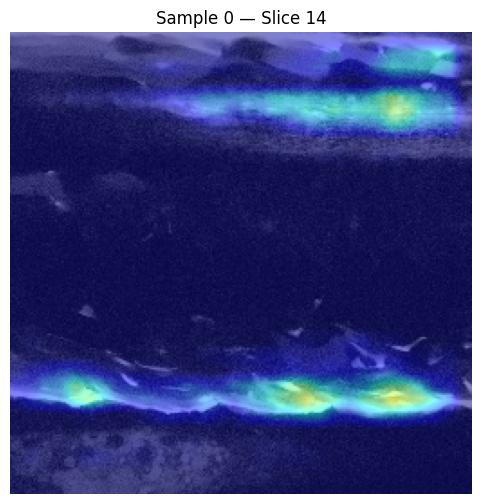

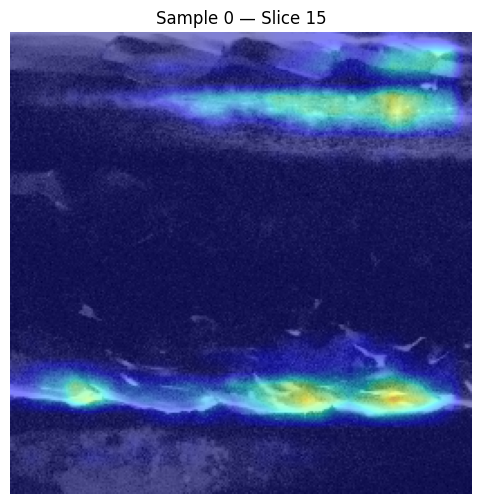

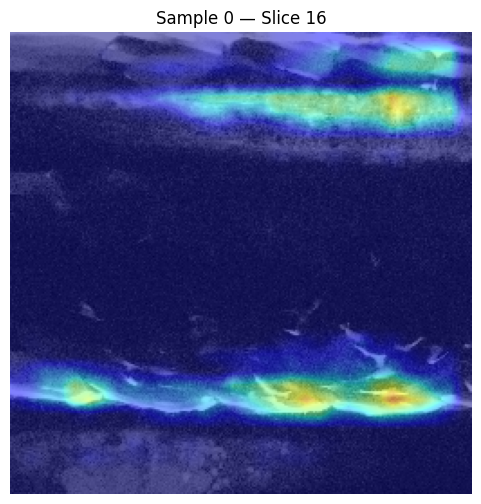

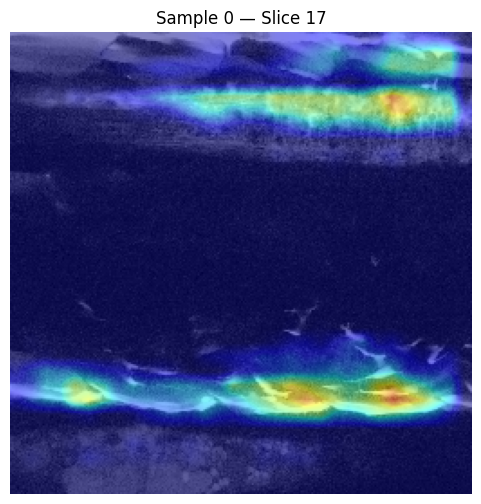

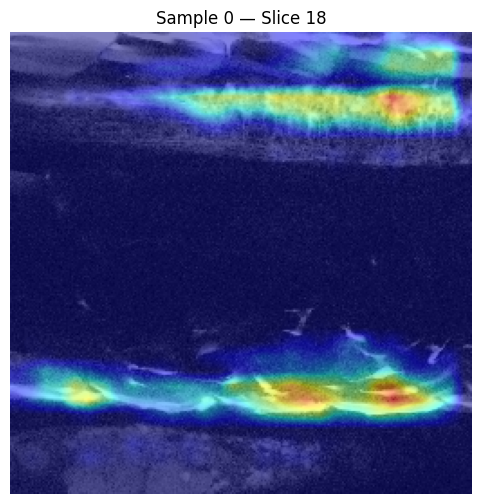

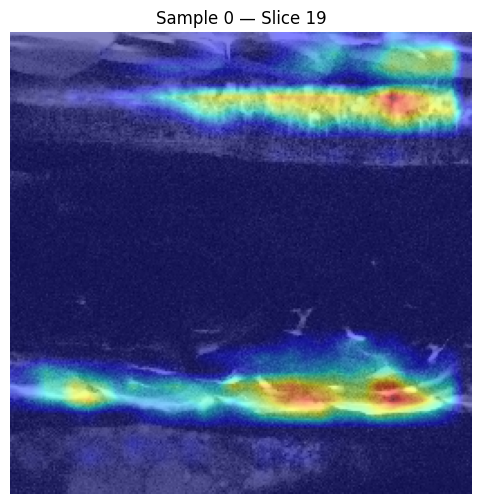

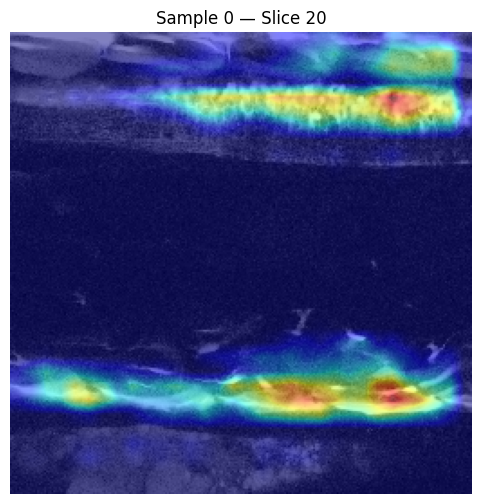

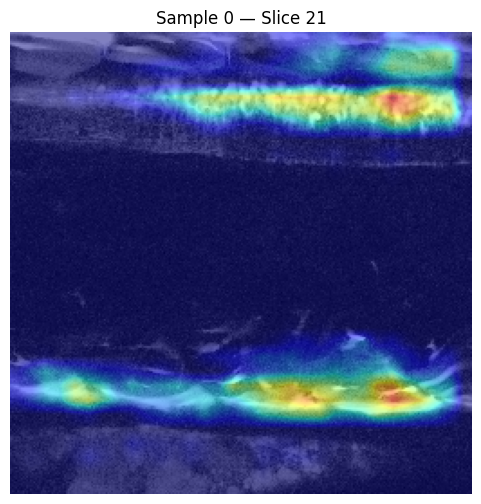

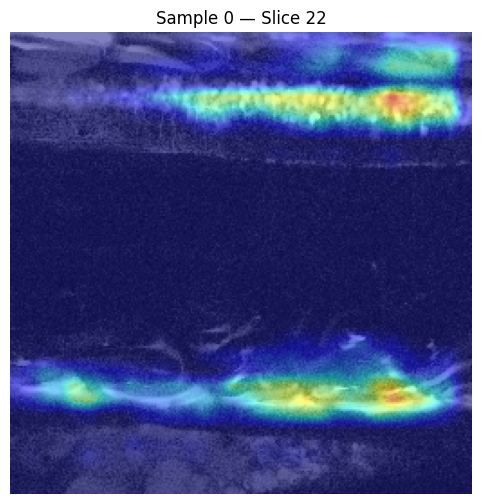

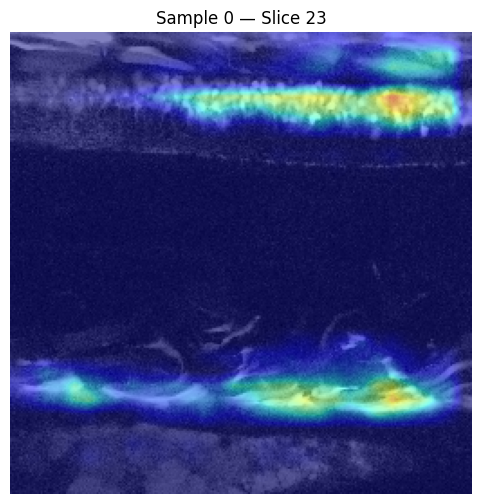

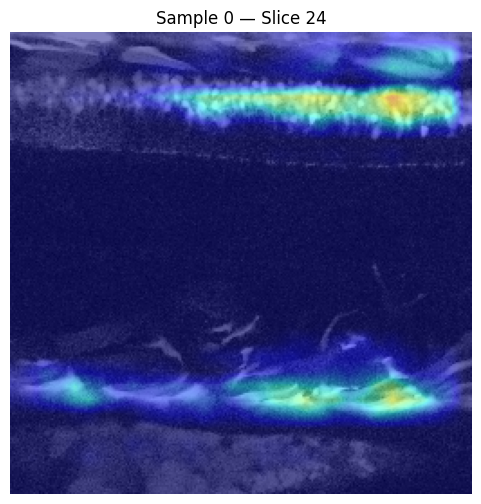

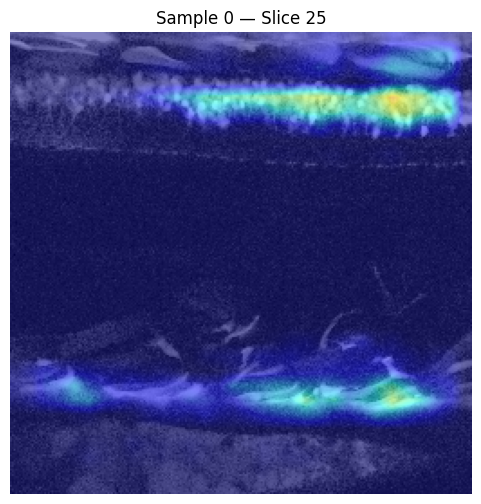

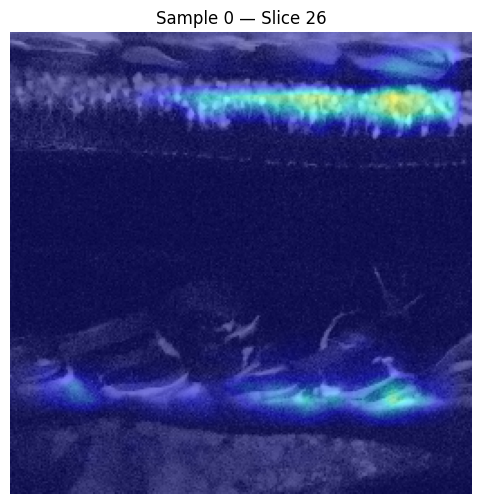

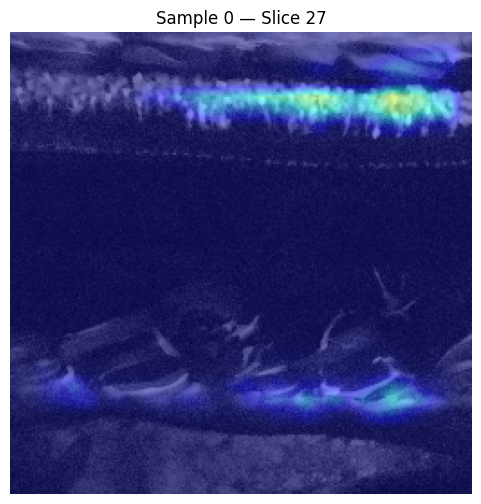

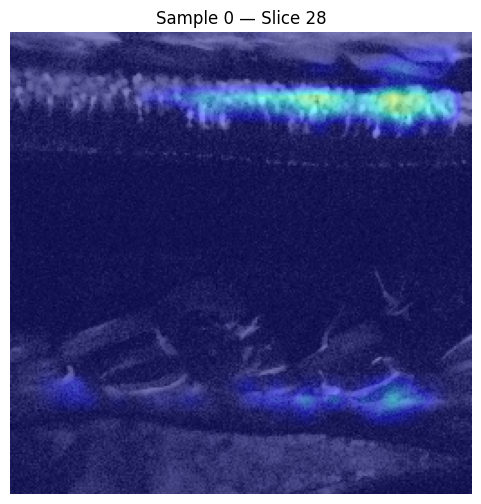

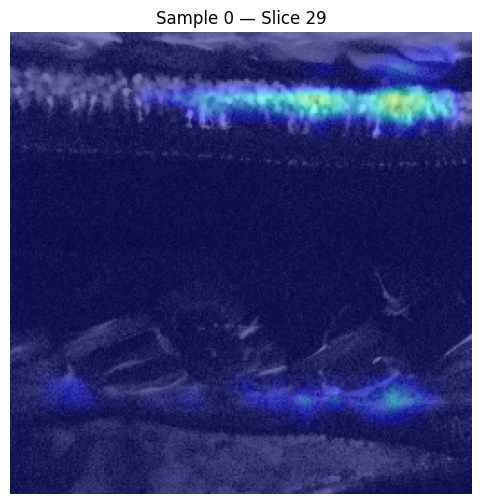

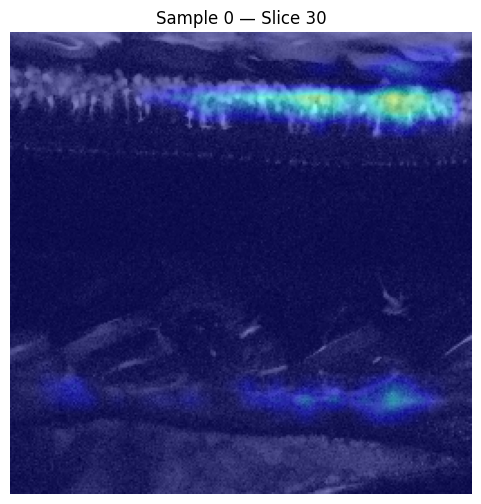

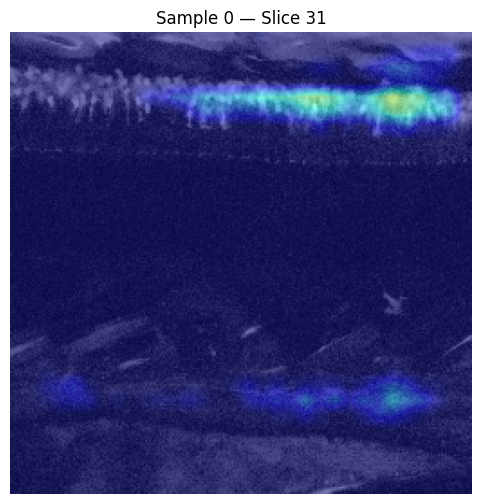

In [5]:
input_data, label = test_set[15]  
input_tensor = input_data.unsqueeze(0)

model = resnet10(sample_input_D=64, sample_input_H=128, sample_input_W=128, nclasses=1)
model.load_state_dict(torch.load("fold2.pth"))
model.eval()

target_layer = model.layer4[0]
gradcam = GradCAM(model, target_layer)

cam = gradcam(input_tensor)  
gradcam.remove_hooks()

D = input_tensor.shape[2]
low_threshold = 1  # can change the threshold according to your needs to control CAM visibility

print(f"\nDisplaying all {D} slices")

for i in range(D):
    img_slice = input_tensor[0, 0, i].cpu().numpy()
    cam_slice = cam[0, 0, i].cpu().numpy()

    low_mask = cam_slice < low_threshold
    masked_cam = np.zeros_like(cam_slice)
    masked_cam[low_mask] = cam_slice[low_mask]

    plt.figure(figsize=(6, 6))
    plt.imshow(img_slice, cmap='gray')
    plt.imshow(masked_cam, cmap='jet', alpha=0.5, vmin=0, vmax=1)
    plt.title(f"Sample 0 — Slice {i}")
    plt.axis('off')
    plt.show()